In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from typing import *

In [22]:
from sensetools.plots import feature_labeller

In [23]:
protein = '1fme'
md_t2 = {'1fme': 18*1000}
# order = [(53, 'fixed_k'), (60, 'fixed_k'), (52, 'fixed_k'), (47, 'worst'), (81, 'timescale_gap'), (60, 'timescale_gap'), (86, 'timescale_gap')]
lag = 41

In [24]:
summary_path = f'{protein}/summary.h5'

selection = pd.read_hdf(summary_path, key='model_selection')
timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
gaps = pd.read_hdf(summary_path, key='timescale_ratio')
gaps.reset_index(inplace=True)
timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)

In [64]:
vamps.head()

,hp_ix,lag,process,median,lb,ub,count,feature
0,28,1,2,1.991242,1.987578,1.997172,100,dihed.
1,28,1,3,2.980015,2.968074,2.987502,100,dihed.
2,28,1,4,3.965492,3.947025,3.975981,100,dihed.
3,28,1,5,4.946920,4.922022,4.963168,100,dihed.
4,28,1,6,5.925580,5.890932,5.947508,100,dihed.


In [25]:
hp_samples = pd.read_hdf('../data/msms/hpsample.h5')

hp_samples.reset_index(inplace=True)

hp_samples['feature'] = hp_samples.apply(feature_labeller, axis=1)
vamps = vamps.merge(hp_samples.loc[:, ['feature', 'hp_ix']], on='hp_ix')
timescales = timescales.merge(hp_samples.loc[:, ['feature', 'hp_ix']], on='hp_ix')

In [26]:
def top_performers_by_feature(vamps: pd.DataFrame, k: int, lag: int)-> Dict[int, int]:
    df = vamps.loc[(vamps.process==k) & (vamps.lag==lag), ['hp_ix', 'median', 'feature']].copy()
    df['rank'] = df.groupby(['feature'])['median'].rank(ascending=False)
    df.sort_values(by='rank', inplace=True)
    d = dict(zip(df['hp_ix'], df['rank']))
    return d


def top_performers(vamps: pd.DataFrame, k: int, lag: int)-> Dict[int, int]:
    df = vamps.loc[(vamps.process==k) & (vamps.lag==lag), ['hp_ix', 'median']].copy()
    df['rank'] = df['median'].rank(ascending=False)
    df.sort_values(by='rank', inplace=True)
    d = dict(zip(df['hp_ix'], df['rank']))
    return d


def plot_val_by_mod_proc(ax, value_df, color='by_proc'): 
    for (mod_n, proc), df in value_df.groupby(['rank', 'process']):
        if mod_n == 1: 
            label = f"{proc}"
        else: 
            label = None
        
        if color=='by_proc':
            col = cols[proc-2]
        else: 
            col = color
#         if proc == 2: 
#             print(mod_n, df['median'])
        ax.hlines(df['median'],  mod_n-width, mod_n+width, color=col, label=label)
        
        ax.fill_between([mod_n-width, mod_n+width], df['lb'], df['ub'], alpha=0.1, color=col)


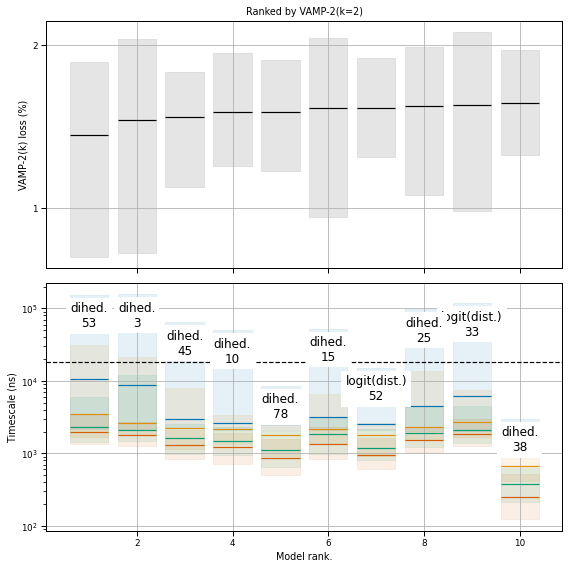

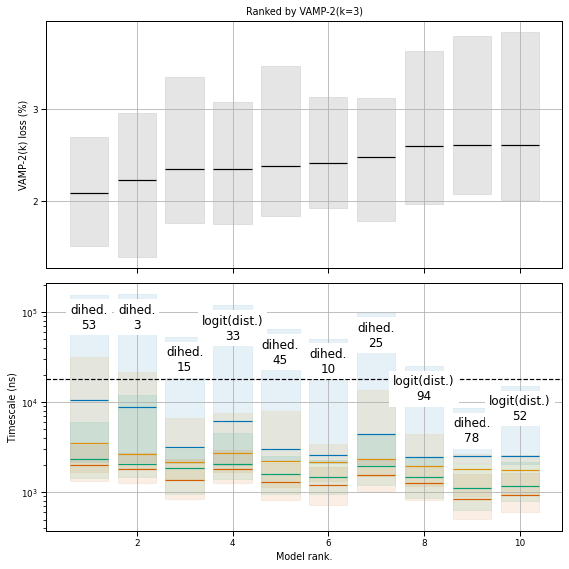

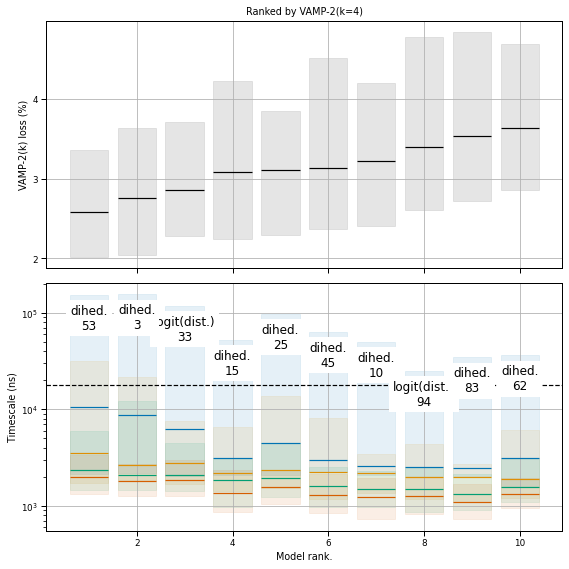

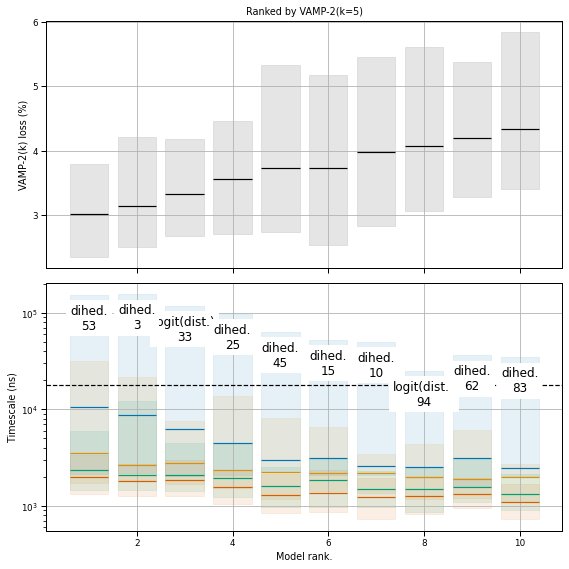

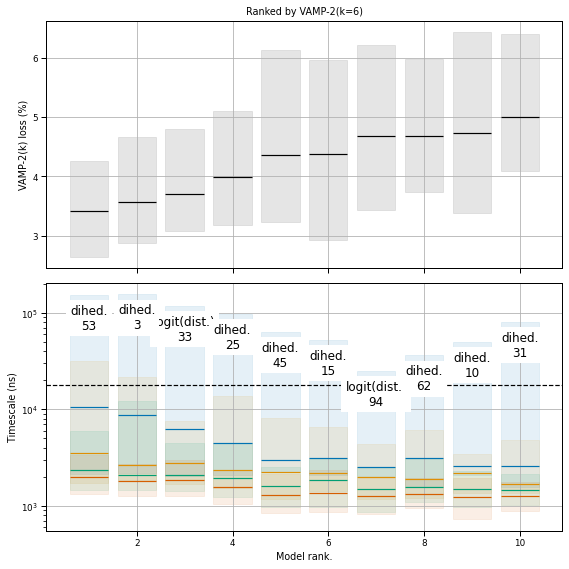

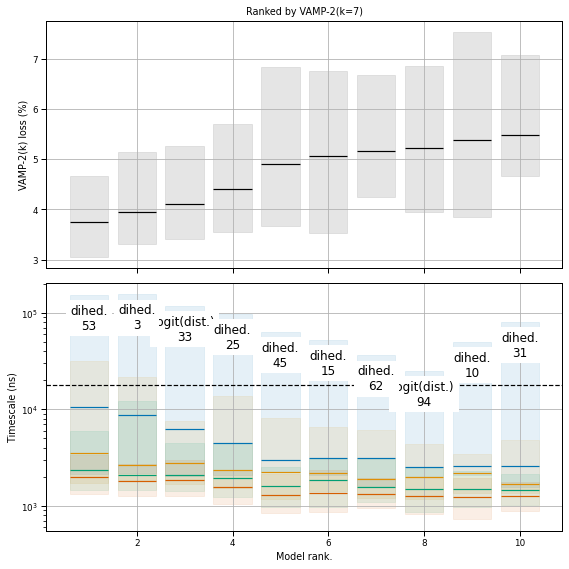

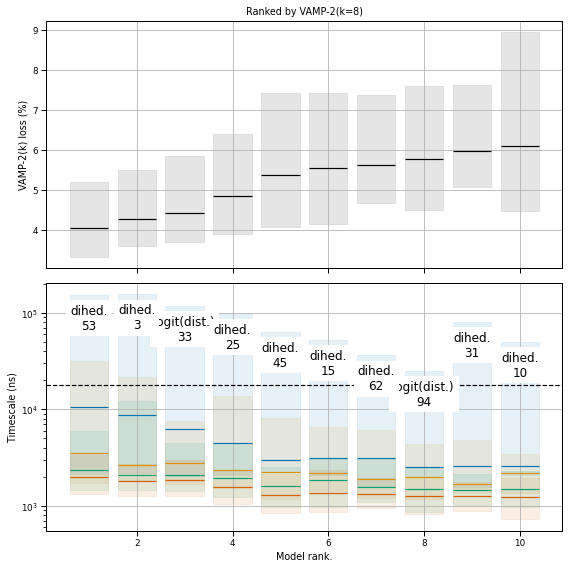

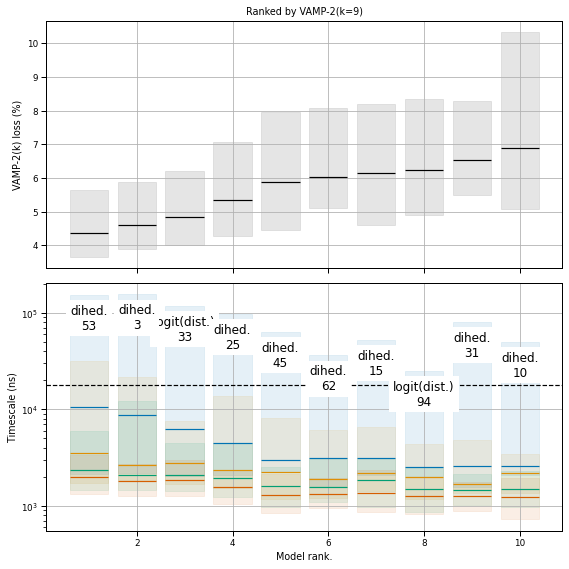

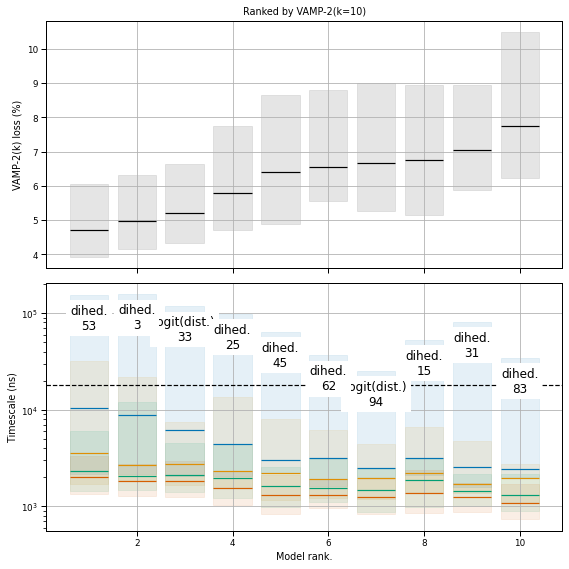

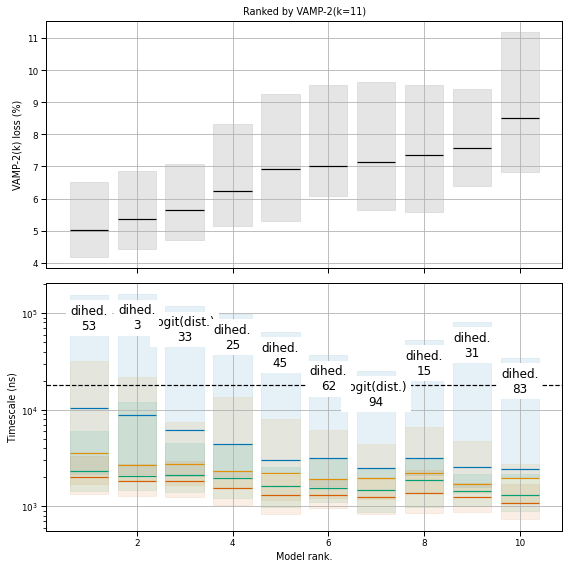

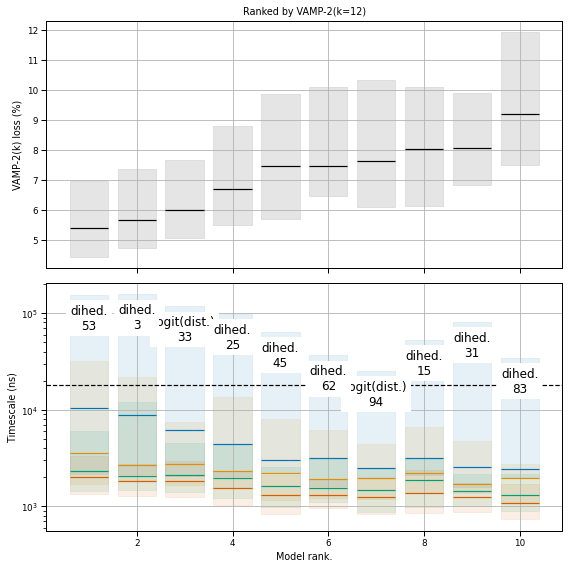

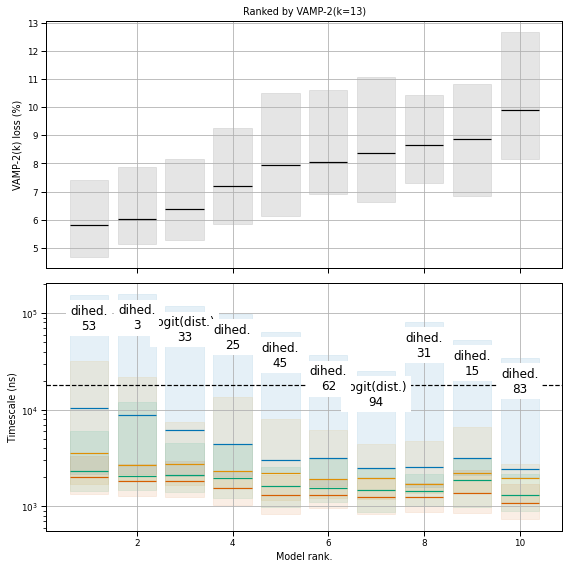

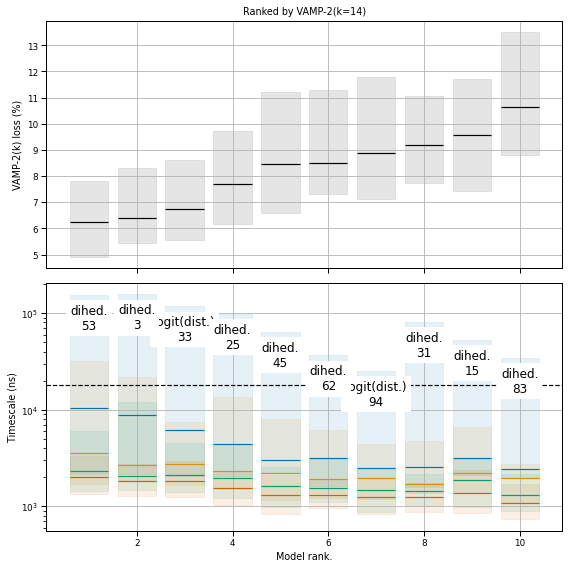

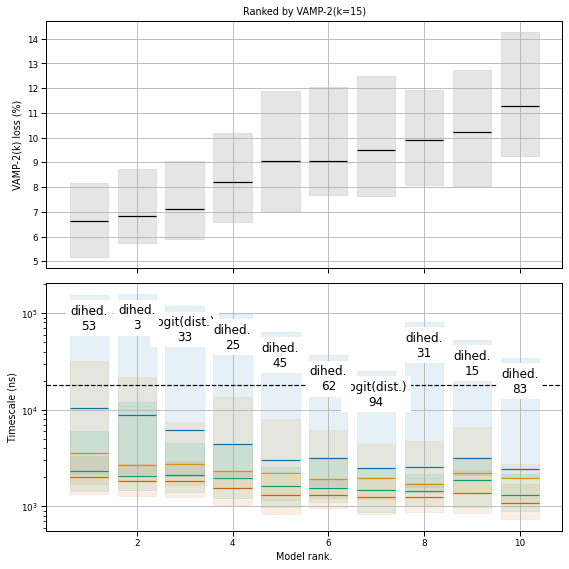

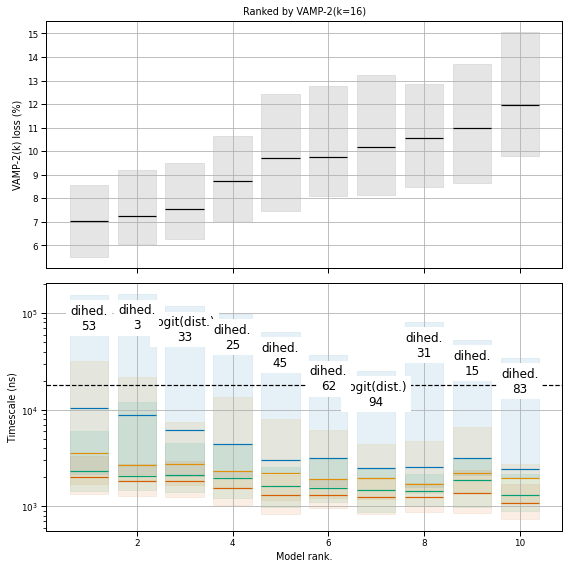

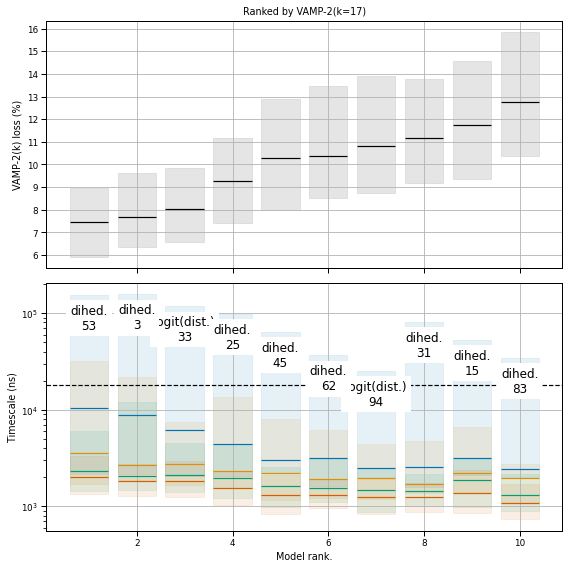

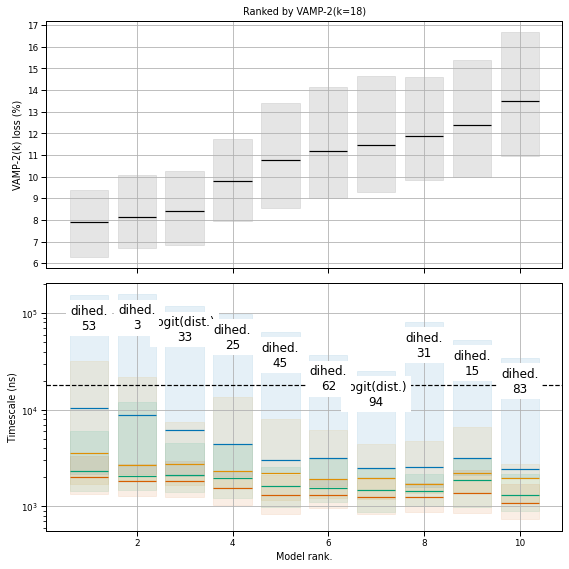

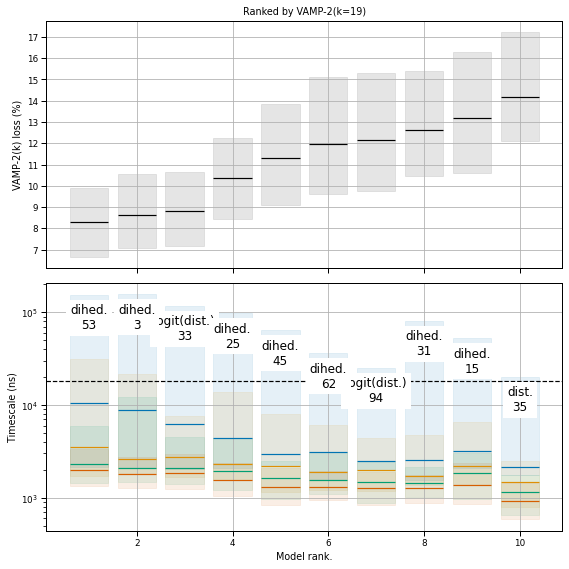

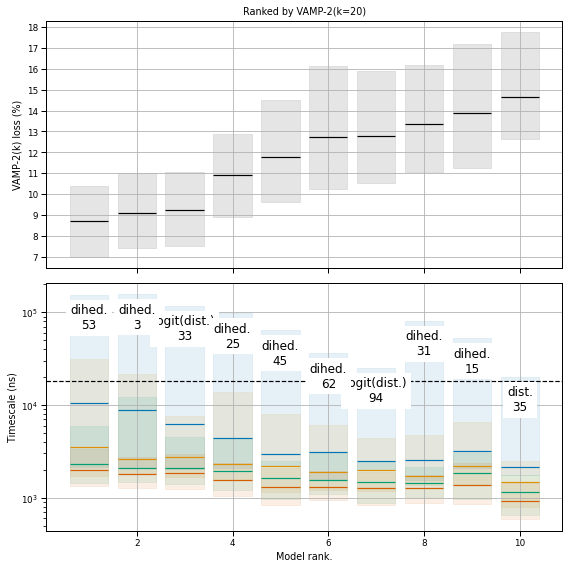

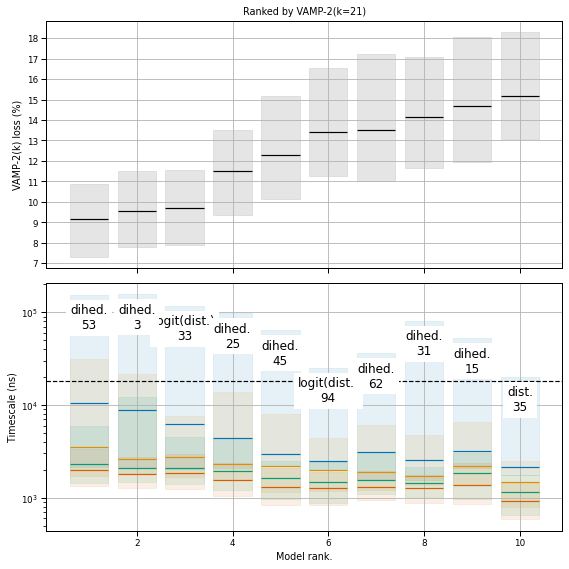

In [27]:
top_n = 10

for k in range(2, 22):

    # Select observables and vamp scores
    top_vamps = vamps.loc[(vamps.process==k) & (vamps.lag==lag), :].copy()
    top_timescales = timescales.loc[timescales.lag == lag, :].copy()

    # rank models
    rank_by_ix = top_performers(vamps, k=k, lag=lag)

    # add ranks to observables/vamps
    top_vamps[f'rank'] = top_vamps['hp_ix'].apply(lambda x: rank_by_ix.get(x))
    top_timescales[f'rank'] = top_timescales['hp_ix'].apply(lambda x: rank_by_ix.get(x))

    # rescale score
    top_vamps['median'] = 100*(1-top_vamps['median']/k)
    top_vamps['lb'] = 100*(1-top_vamps['lb']/k)
    top_vamps['ub'] = 100*(1-top_vamps['ub']/k)
    
    with sns.plotting_context('paper', font_scale=1): 
        width =0.4
        offset = 0.5
        fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

        cols = sns.color_palette('colorblind', timescales.process.max())

        vamp_ax = axes[0]

        plot_val_by_mod_proc(vamp_ax, top_vamps.query(f"rank <= {top_n}"), color='k')
        vamp_ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        vamp_ax.set_ylabel('VAMP-2(k) loss (%)')
#         axes[0].set_yscale('log')

        time_ax = axes[1]
        plot_val_by_mod_proc(time_ax, top_timescales.query('process <= 5').query(f"rank <= {top_n}"))
        time_ax.set_yscale('log')
        time_ax.set_ylabel('Timescale (ns)')
        for ix, df in top_timescales.query(f"rank <= {top_n}").query('process == 2').iterrows(): 
            time_ax.annotate(text=f"{df.feature}\n{df.hp_ix}", xy=(df['rank'], df.ub*0.8), 
                             verticalalignment='top', 
                              horizontalalignment='center', bbox={'facecolor': 'white', 'linewidth': 0}, fontsize=12)

        xlim = time_ax.get_xlim()    
        time_ax.hlines(md_t2[protein], *xlim, color='k',ls='dashed')
        time_ax.set_xlim(xlim)
        
        axes[-1].set_xlabel('Model rank.')
        axes[0].set_title(f'Ranked by VAMP-2(k={k})')
#         axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
        axes[0].grid()
        axes[1].grid()
        for ax in axes.flatten():
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))

        plt.tight_layout()
        plt.savefig(f'{protein}/{protein}_timescale_comarison_by_rank_k_{k}.png', bbox_inches='tight')

In [28]:
vamps.loc[vamps.hp_ix.isin([53, 38]) & (vamps.lag == 41) & (vamps.process == 2)]

,hp_ix,lag,process,median,lb,ub,count,feature
3315,53,41,2,1.970976,1.962065,1.986006,100,dihed.
19214,38,41,2,1.967134,1.960596,1.973448,100,dihed.


In [29]:
timescales.loc[timescales.hp_ix.isin([53, 38]) & (timescales.lag == 41) & (timescales.process == 2)]

,hp_ix,lag,process,median,lb,ub,count,feature
3315,53,41,2,10462.112332,2147.640400,155045.410914,100,dihed.
19214,38,41,2,2409.852808,2015.099563,3012.630813,100,dihed.


In [31]:
from pathlib import Path

In [40]:
!pwd

/Users/robertarbon/Documents/Research/msm_sensitivity_analysis/analysis


In [58]:
dtrajs = [np.load(x) for x in Path('../data/msms/1fme/dtrajs/hp_52/').glob('1FME-*-protein-*.npy')]

In [59]:
len(dtrajs)

164

In [60]:
import pyemma as pm

mod = pm.msm.estimate_markov_model(dtrajs, lag=41)

In [61]:
mod.score(dtrajs, score_k=2)

1.9414362364641682

In [63]:
mod.timescales()[0]

1338.2754937548875